In [29]:
import os
import re
import json
from pathlib import Path
import yaml

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
import skimage
import pandas as pd
import tifffile
from einops import rearrange, repeat
from pydantic_extra_types.color import Color

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
import mushroom.utils as utils
import mushroom.visualization.utils as vis_utils

In [6]:
project_dir = Path('/data/estorrs/mushroom/data/projects/submission_v1')
region_dir = project_dir / 'analysis' / 'region_characterization'
fig_dir = region_dir / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)
results_dir = region_dir / 'results'
results_dir.mkdir(parents=True, exist_ok=True)

In [7]:
source_root = '/diskmnt/Projects/Users/estorrs/mushroom/data'
target_root = '/data/estorrs/mushroom/data'

def alter_filesystem(config, source_root, target_root):
    for entry in config['sections']:
        for mapping in entry['data']:
            mapping['filepath'] = mapping['filepath'].replace(source_root, target_root)
    
    if 'trainer_kwargs' in config and config['trainer_kwargs']['data_mask'] is not None:
        config['trainer_kwargs']['data_mask'] = config['trainer_kwargs']['data_mask'].replace(source_root, target_root)
        
    return config

In [37]:
fps = sorted(utils.listfiles(region_dir, regex=r'_regions.txt.gz$'))

sid_to_data = {}
for fp in fps:
    name = fp.split('/')[-1]
    sid = re.sub(r'^(.*)_regions.txt.gz$', r'\1', name)
    print(sid)
    case = re.sub(r'^(.*)-U[0-9]+$', r'\1', sid)

    config = yaml.safe_load(open(project_dir / case / 'registered' / 'metadata.yaml'))
    config = alter_filesystem(config, source_root, target_root)

    imaris_dir = project_dir / case / 'imaris' / 'rois'
    meta = json.load(open(imaris_dir / 'tiled' / 'metadata.json'))
    
    sid_to_channels = meta['sid_to_channels']
    dtype_ident_to_dtype = meta['dtype_ident_to_dtype']
    sid_to_dtype_ident = meta['sid_to_dtype_ident']
    
    full_rgb_no_dir = imaris_dir / 'full_rgbs_no_overlays'

    if sid in sid_to_channels:
        channels = sid_to_channels[sid]
        dti = sid_to_dtype_ident[sid]
        dtype = dti.split('_')[0]
        dtype2 = 'xenium5k' if dtype == 'xenium' and len(channels) > 2000 else dti.split('_')[0]
    else:
        raise RuntimeError()

    if case in ['HT891Z1', 'HT913Z1', 'S18-5591-C8', 'S18-9906']:
        disease = 'prad'
    else:
        disease = 'brca'

    mapping = None
    position = None
    for entry in config['sections']:
        if entry['sid'] == sid:
            for item in entry['data']:
                if item['dtype'] == dtype:
                    mapping = item
                    position = entry['position']
                    break
    assert mapping is not None

    if dtype in ['he', 'multiplex']:
        data = {
            'filepath': mapping['filepath']
        }

    elif dtype in ['xenium', 'cosmx']:
        data = {
            'adata': mapping['filepath'],
            'transcripts': mapping['filepath'].replace('.h5ad', '_transcripts.parquet'),
            'morphology': mapping['filepath'].replace('.h5ad', '_morphologyfocus.ome.tiff')
        }
    elif dtype in ['vishd']:
        data = {
            'adata': mapping['filepath'],
            'he': mapping['filepath'].replace('.h5ad', '_he.ome.tiff')
        }
    else:
        raise RuntimeError(f'dtype {dtype} not valid')

    for k, v in data.items():
        assert os.path.exists(v)
    
    rgb_fp = full_rgb_no_dir / f'{sid}.tif'
    if not os.path.exists(rgb_fp):
        rgb_fp = imaris_dir / 'full_rgbs' / f'{sid}.tif'
        if not os.path.exists(rgb_fp):
            print('no rgb', sid)
            rgb_fp = None

    sid_to_data[sid] = {
        'case': case,
        'sid': sid,
        'position': position,
        'channels': channels,
        'dti': dti,
        'dtype': dtype,
        'dtype2': dtype2,
        'rgb': rgb_fp,
        'labeled_regions': fp.replace('_regions.txt.gz', '_regions.tif'),
        'labeled_boundaries': fp.replace('_regions.txt.gz', '_boundaries.tif'),
        'labeled_tme': fp.replace('_regions.txt.gz', '_tme.tif'),
        'data': data,
    }

HT206B1-U10
HT206B1-U13
HT206B1-U16
HT206B1-U17
HT206B1-U18
HT206B1-U1
HT206B1-U21
HT206B1-U24
HT206B1-U2
HT206B1-U5
HT206B1-U8
HT206B1-U9
HT339B2-H1-U2
HT397B1-U12
HT397B1-U22
HT397B1-U2
HT397B1-U31
HT565B1-H2-U2
HT704B1-U11
HT704B1-U14
HT704B1-U17
HT704B1-U19
HT704B1-U1
HT704B1-U22
HT704B1-U26
HT704B1-U27
HT704B1-U2
HT704B1-U33
HT704B1-U35
HT704B1-U41
HT704B1-U43
HT704B1-U47
HT704B1-U50
HT704B1-U51
HT704B1-U53
HT704B1-U56
HT704B1-U60
HT704B1-U68
HT704B1-U76
HT704B1-U82
HT704B1-U85
HT704B1-U91
HT891Z1-U103
HT891Z1-U104
HT891Z1-U108
HT891Z1-U109
HT891Z1-U110
HT891Z1-U111
HT891Z1-U113
HT891Z1-U14
HT891Z1-U1
HT891Z1-U21
HT891Z1-U2
HT891Z1-U31
HT891Z1-U32
HT891Z1-U33
HT891Z1-U40
HT891Z1-U41
HT891Z1-U43
HT891Z1-U44
HT891Z1-U45
HT891Z1-U46
HT891Z1-U58
HT891Z1-U59
HT891Z1-U69
HT891Z1-U79
HT891Z1-U81
HT891Z1-U93
HT891Z1-U94
HT913Z1-U101
HT913Z1-U102
HT913Z1-U111
HT913Z1-U11
HT913Z1-U121
HT913Z1-U125
HT913Z1-U12
HT913Z1-U1
HT913Z1-U21
HT913Z1-U22
HT913Z1-U2
HT913Z1-U33
HT913Z1-U34
HT913Z1-U35


## visualization functions

In [191]:
def plot_xenium_pseudo(ax, rgb, transcripts, view_settings, s=.1):
    ax.imshow(rgb)
    
    if not isinstance(transcripts, pd.DataFrame):
        transcripts = pd.read_parquet(transcripts)
        
    pool = set(transcripts['feature_name'])
    for entry in view_settings:
        color = np.asarray(Color(entry['color']).as_rgb_tuple()) / 255.
        channel = entry['channel']
        marker = entry['marker']
        
        if channel in pool:
            small = transcripts[transcripts['feature_name']==channel]
            X = small[['y_location', 'x_location']].values.astype(int)
            ax.scatter(X[:, 1], X[:, 0], color=color, s=s, marker=marker, edgecolors='none')
    return ax

def add_transcripts_to_rgb(rgb, transcripts, xenium_view_settings, pt_scaler=50, bbox=None):
    if not isinstance(transcripts, pd.DataFrame):
        transcripts = pd.read_parquet(transcripts)

    if bbox is not None:
        r1, r2, c1, c2 = bbox
        rgb = rgb[r1:r2, c1:c2]

        m = (transcripts['y_location'] > r1) & (transcripts['y_location'] < r2)
        m &= (transcripts['x_location'] > c1) & (transcripts['x_location'] < c2)
        transcripts = transcripts[m]
        transcripts['y_location'] -= r1
        transcripts['x_location'] -= c1

    size = (rgb.shape[1] / 1000, rgb.shape[0] / 1000)
    fig, ax = plt.subplots(figsize=(rgb.shape[1] / 1000, rgb.shape[0] / 1000))
    ax.set_axis_off()
    ax = plot_xenium_pseudo(ax, rgb, transcripts, xenium_view_settings, s=size[0] / pt_scaler)
    plt.savefig('temp.tif', bbox_inches='tight', pad_inches=0, dpi=int(1000 * 1.2987411728584588))
    rgb = tifffile.imread('temp.tif')
    os.remove('temp.tif')
    plt.close()
    
    if rgb.shape[-1] == 4:
        rgb = rgb[..., :-1]
    
    return rgb

def get_st_rgb(rgb_fp, transcripts_fp, view_settings, bbox=None, pt_scaler=50, black=False):
    rgb = tifffile.imread(rgb_fp)

    if black:
        rgb[...] = 0
        
    rgb = add_transcripts_to_rgb(
        rgb, transcripts_fp,
        view_settings,
        bbox=bbox,
        pt_scaler=pt_scaler
    )
    return rgb

def get_st_simple(transcripts, view_settings, ax, bbox=None, s=1):
    if not isinstance(transcripts, pd.DataFrame):
        transcripts = pd.read_parquet(transcripts)

    if bbox is not None:
        r1, r2, c1, c2 = bbox

        m = (transcripts['y_location'] > r1) & (transcripts['y_location'] < r2)
        m &= (transcripts['x_location'] > c1) & (transcripts['x_location'] < c2)
        transcripts = transcripts[m]
        transcripts['y_location'] -= r1
        transcripts['x_location'] -= c1

    pool = set(transcripts['feature_name'])
    for entry in view_settings:
        color = np.asarray(Color(entry['color']).as_rgb_tuple()) / 255.
        channel = entry['channel']
        marker = entry['marker']
        
        if channel in pool:
            small = transcripts[transcripts['feature_name']==channel]
            X = small[['y_location', 'x_location']].values.astype(int)
            ax.scatter(X[:, 1], X[:, 0], color=color, s=s, marker=marker, edgecolors='none')
            ax.axis('equal')
            ax.set_xticks([])
            ax.set_yticks([])

In [205]:
def add_bins_to_rgb(rgb, pts, color='white', pt_scaler=1, marker='s'):
    size = (rgb.shape[1] / 1000, rgb.shape[0] / 1000)
    fig, ax = plt.subplots(figsize=(rgb.shape[1] / 1000, rgb.shape[0] / 1000))
    ax.set_axis_off()
    ax.imshow(rgb)
    ax.scatter(pts[:, 1], pts[:, 0], color=color, s=pt_scaler / 10, marker=marker, edgecolors='none')
    plt.savefig('temp.tif', bbox_inches='tight', pad_inches=0, dpi=int(1000 * 1.2987411728584588))
    plt.close()
    rgb = tifffile.imread('temp.tif')
    os.remove('temp.tif')
    
    if rgb.shape[-1] == 4:
        rgb = rgb[..., :-1]
    
    return rgb

def get_vishd_rgb(rgb, adata, gene, pt_scaler=1):
    if gene in adata.var.index:
        mask = adata[:, gene].X.toarray().flatten() > 0
        pts = adata.obs[['y_location', 'x_location']].values
    
        filtered_pts = pts[mask]
        vals = adata[mask, gene].X.toarray().flatten()
        rgb = add_bins_to_rgb(rgb, filtered_pts, color='white', pt_scaler=pt_scaler)
    return rgb

In [34]:
case_to_rois = {
    'HT891Z1': {
        'roi1': (1300, 2100, 2500, 3500), # normal -> gp3
        'roi2': (4650, 5650, 1900, 2900), # normal -> gp3
        'roi2-p2': (4650, 5650, 1900, 2900), # PIN -> gp3
    },
    'HT913Z1': {
        'roi1': (4000, 4750, 5800, 7200), # normal -> gp3
        'roi1-p2': (4000, 4750, 5800, 7200) # normal -> gp3
    },
    'HT704B1': {
        'roi1': (2400, 3000, 5800, 6600), # DCIS -> IDC
        'roi2': (3700, 4300, 5750, 6500), # DCIS -> partial IDC
        'roi3': (0, 7250, 0, 9063), # full region trace of dcis
    },
    'HT206B1': {
        'roi1': (1650, 2600, 4900, 5750), # dcis -> idc
        'roi2': (2700, 4300, 3600, 5500) # dcis -> idc
    },
    'HT397B1': {
        'roi1': (2600, 3700, 3200, 4800) # dcis -> idc
    }
}

In [59]:
for sid, data in sid_to_data.items():
    if 'HT206B1' in sid:
        print(sid, data['position'])

HT206B1-U10 50
HT206B1-U13 65
HT206B1-U16 80
HT206B1-U17 85
HT206B1-U18 90
HT206B1-U1 0
HT206B1-U21 105
HT206B1-U24 120
HT206B1-U2 15
HT206B1-U5 20
HT206B1-U8 40
HT206B1-U9 45


In [170]:
case_to_targets = {
    'xenium': {
        'HT891Z1': {
            'roi1': [
                {'sid': 'HT891Z1-U104', 'center': [1850, 3080], 'radius': 110},
                {'sid': 'HT891Z1-U69', 'center': [1820, 2940], 'radius': 130},
                {'sid': 'HT891Z1-U59', 'center': [1770, 2960], 'radius': 210},
                {'sid': 'HT891Z1-U44', 'center': [1630, 2830], 'radius': 130},
                {'sid': 'HT891Z1-U31', 'center': [1590, 2770], 'radius': 120}
            ],
            'roi2': [
                {'sid': 'HT891Z1-U31', 'center': [4820, 2090], 'radius': 145},
                {'sid': 'HT891Z1-U21', 'center': [4850, 2190], 'radius': 145},
                {'sid': 'HT891Z1-U21', 'center': [5310, 2440], 'radius': 380},
                {'sid': 'HT891Z1-U59', 'center': [5370, 2390], 'radius': 210},
                {'sid': 'HT891Z1-U81', 'center': [5420, 2230], 'radius': 120}
            ],
        },
        'HT913Z1': {
            'roi1': [
                {'sid': 'HT913Z1-U21', 'center': [4410, 6590], 'radius': 270},
                {'sid': 'HT913Z1-U61', 'center': [4440, 6340], 'radius': 120},
                {'sid': 'HT913Z1-U81', 'center': [4350, 6180], 'radius': 150},
                {'sid': 'HT913Z1-U101', 'center': [4510, 6170], 'radius': 200},
                {'sid': 'HT913Z1-U21', 'center': [4490, 6750], 'radius': 150},
            ]
        },
        'HT704B1': {
            'roi1': [
                {'sid': 'HT704B1-U1', 'center': [2750, 6350], 'radius': 170},
                {'sid': 'HT704B1-U33', 'center': [2670, 6000], 'radius': 210},
                {'sid': 'HT704B1-U41', 'center': [2810, 5970], 'radius': 130},
                {'sid': 'HT704B1-U50', 'center': [2600, 6040], 'radius': 250},
            ],
        },
        'HT206B1': {
            'roi2': [
                {'sid': 'HT206B1-U8', 'center': [3650, 4700], 'radius': 500},
                {'sid': 'HT206B1-U24', 'center': [3900, 5080], 'radius': 100},
            ],
        },
    },
    'vishd': {
        'HT891Z1': {
            'roi1': [
                {'sid': 'HT891Z1-U2', 'center': [4820, 2090], 'radius': 350},
                {'sid': 'HT891Z1-U33', 'center': [4820, 2090], 'radius': 350},
            ]
        },
        'HT704B1': {
            'roi1': [
                {'sid': 'HT704B1-U2', 'center': [2750, 6350], 'radius': 170},
                {'sid': 'HT704B1-U51', 'center': [2600, 6040], 'radius': 250},
            ]
        },
    },
    'cosmx': {
        'HT704B1': {
            'roi1': [
            ]
        }
    }
}

In [171]:
case_to_roidata = {}

for dtype, d in case_to_targets.items():
    case_to_roidata[dtype] = {}
    for case, d1 in d.items():
        case_to_roidata[dtype][case] = {}
        for roi, entry in d1.items():
            case_to_roidata[dtype][case][roi] = {}
            for j, d in enumerate(entry):
                print(case, roi, d['sid'], dtype)
                sid = d['sid']
                r, c = d['center']
                radius = d['radius']
    
                bbox = r - radius, r + radius, c - radius, c + radius
                r1, r2, c1, c2 = bbox
            
                data = sid_to_data[sid]

                if dtype in ['xenium', 'cosmx']:
                    transcripts_fp = data['data']['transcripts']
                    rgb_fp = data['rgb']
    
                    rgb = tifffile.imread(rgb_fp)[r1:r2, c1:c2]
        
                    transcripts = pd.read_parquet(transcripts_fp)
                    m = (transcripts['y_location'] > r1) & (transcripts['y_location'] < r2)
                    m &= (transcripts['x_location'] > c1) & (transcripts['x_location'] < c2)
                    transcripts = transcripts[m]
                    transcripts['y_location'] -= r1
                    transcripts['x_location'] -= c1
        
                    case_to_roidata[dtype][case][roi][sid] = {
                        'dtype': dtype,
                        'rgb': rgb,
                        'transcripts': transcripts
                    }
                elif dtype == 'vishd':
                    adata_fp = data['data']['adata']
                    rgb_fp = data['rgb']

                    rgb = tifffile.imread(rgb_fp)[r1:r2, c1:c2]
                    
                    adata = sc.read_h5ad(adata_fp)
                    m = (adata.obs['y_location'] > r1) & (adata.obs['y_location'] < r2)
                    m &= (adata.obs['x_location'] > c1) & (adata.obs['x_location'] < c2)
                    adata = adata[m]
                    adata.obs['y_location'] -= r1
                    adata.obs['x_location'] -= c1

                    case_to_roidata[dtype][case][roi][sid] = {
                        'dtype': dtype,
                        'rgb': rgb,
                        'adata': adata
                    }

HT891Z1 roi1 HT891Z1-U104 xenium
HT891Z1 roi1 HT891Z1-U69 xenium
HT891Z1 roi1 HT891Z1-U59 xenium
HT891Z1 roi1 HT891Z1-U44 xenium
HT891Z1 roi1 HT891Z1-U31 xenium
HT891Z1 roi2 HT891Z1-U31 xenium
HT891Z1 roi2 HT891Z1-U21 xenium
HT891Z1 roi2 HT891Z1-U21 xenium
HT891Z1 roi2 HT891Z1-U59 xenium
HT891Z1 roi2 HT891Z1-U81 xenium
HT913Z1 roi1 HT913Z1-U21 xenium
HT913Z1 roi1 HT913Z1-U61 xenium
HT913Z1 roi1 HT913Z1-U81 xenium
HT913Z1 roi1 HT913Z1-U101 xenium
HT913Z1 roi1 HT913Z1-U21 xenium
HT704B1 roi1 HT704B1-U1 xenium
HT704B1 roi1 HT704B1-U33 xenium
HT704B1 roi1 HT704B1-U41 xenium
HT704B1 roi1 HT704B1-U50 xenium
HT206B1 roi2 HT206B1-U8 xenium
HT206B1 roi2 HT206B1-U24 xenium
HT891Z1 roi1 HT891Z1-U2 vishd


/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_1916471/579548059.py:48: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['y_location'] -= r1


HT891Z1 roi1 HT891Z1-U33 vishd


/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_1916471/579548059.py:48: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['y_location'] -= r1


HT704B1 roi1 HT704B1-U2 vishd


/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_1916471/579548059.py:48: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['y_location'] -= r1


HT704B1 roi1 HT704B1-U51 vishd


/data/estorrs/miniconda3/envs/mushroom_v2/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_1916471/579548059.py:48: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['y_location'] -= r1


In [212]:
# case_to_idx = {case:i for i, case in enumerate(case_to_roidata['xenium'].items())}
# case_to_pos = {case:0 for case in case_to_idx.keys()}
def show_rois(view_settings, figsize=(6, 8), black=False, dtype_to_pt_scaler={}):
    count = 0
    ls = []
    for dtype, d in case_to_roidata.items():
        for case, d1 in d.items():
            for roi, d2 in d1.items():
                for j, (sid, roidata) in enumerate(d2.items()):
                    if dtype in ['xenium', 'vishd']:
                        count += 1
                        ls.append(len(d2))
                        break

    nrows = count
    ncols = np.max(ls)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    i = -1
    for dtype, d in case_to_roidata.items():
        for case, d1 in d.items():
            for roi, d2 in d1.items():
                if len(d2):
                    i += 1
                    for j, (sid, roidata) in enumerate(d2.items()):
                        ax = axs[i, j]
        
                        if dtype == 'xenium':
                            transcripts = roidata['transcripts']
                            rgb = roidata['rgb']
                        
                            x = add_transcripts_to_rgb(rgb, transcripts, view_settings, pt_scaler=dtype_to_pt_scaler.get(dtype, 1), bbox=None)
        
                        if dtype == 'vishd':
                            adata = roidata['adata']
                            rgb = roidata['rgb']
                        
                            x = get_vishd_rgb(rgb, adata, view_settings[-1]['channel'], pt_scaler=dtype_to_pt_scaler.get(dtype, 1))
                        
                        ax.imshow(x)
                        ax.set_title(sid)
                        case_to_pos[case] += 1

    for ax in axs.flatten():
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(6)
        ax.axis('off')


7 5


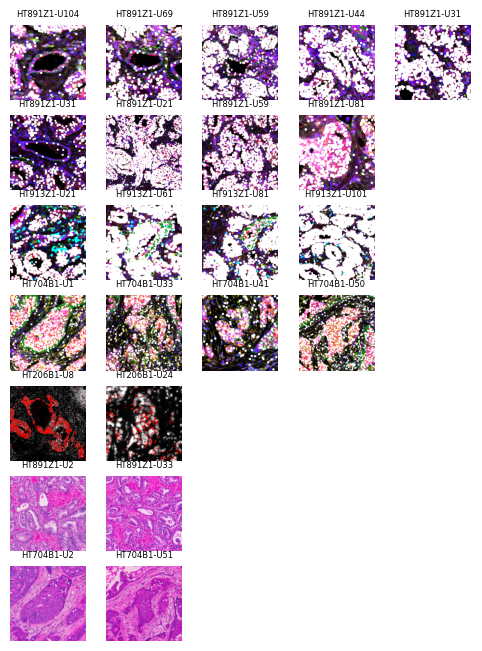

In [211]:
view_settings = [
    {
        'channel': 'EPCAM',
        'color': 'red',
        'marker': '.',
    },
    {
        'channel': 'KRT5',
        'color': 'green',
        'marker': '.',
    },
    {
        'channel': 'AMACR',
        'color': 'white',
        'marker': 's',
    }
]

show_rois(view_settings, dtype_to_pt_scaler={'xenium': 2, 'vishd': 1})

In [213]:
for gene in genes:
    print(gene)
    view_settings = [
        {
            'channel': 'EPCAM',
            'color': 'red',
            'marker': '.',
        },
        {
            'channel': 'KRT5', 
            'color': 'white',
            'marker': '.',
        },
        {
            'channel': gene,
            'color': 'limegreen',
            'marker': '.',
        }
    ]

    show_rois(view_settings)
    plt.show()

In [23]:
sid = 'HT704B1-U1'
data = sid_to_data[sid]
data.keys()

dict_keys(['case', 'sid', 'channels', 'dti', 'dtype', 'dtype2', 'rgb', 'labeled_regions', 'labeled_boundaries', 'labeled_tme', 'data'])

In [24]:
data['data']

{'adata': '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s0_HT704B1-U1_xenium.h5ad',
 'transcripts': '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s0_HT704B1-U1_xenium_transcripts.parquet',
 'morphology': '/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/registered/s0_HT704B1-U1_xenium_morphologyfocus.ome.tiff'}

In [25]:
data['rgb']

PosixPath('/data/estorrs/mushroom/data/projects/submission_v1/HT704B1/imaris/rois/full_rgbs_no_overlays/HT704B1-U1.tif')

In [27]:
view_settings = [
    {
        'channel': 'EPCAM',
        'color': 'red',
        'marker': '.',
    },
    {
        'channel': 'HLA-DQB2',
        'color': 'yellow',
        'marker': 'v',
    },
    {
        'channel': 'TP63',
        'color': 'white',
        'marker': 's',
    },
    {
        'channel': 'KRT5',
        'color': 'white',
        'marker': 's',
    },
    {
        'channel': 'CP',
        'color': 'purple',
        'marker': 'P',
    },
    {
        'channel': 'CD3E',
        'color': 'limegreen',
        'marker': '*',
    },
    {
        'channel': 'CD68',
        'color': 'cyan',
        'marker': 'D',
    },
]

In [32]:
rgb = get_st_rgb(data['rgb'], data['data']['transcripts'], view_settings)
rgb.shape

(7246, 9058, 3)

<Figure size 906.3x725 with 0 Axes>

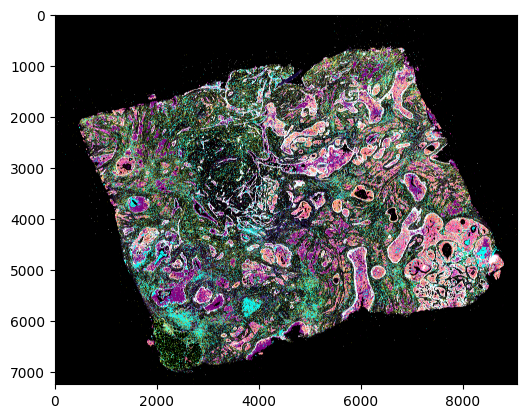

In [36]:
plt.imshow(rgb)

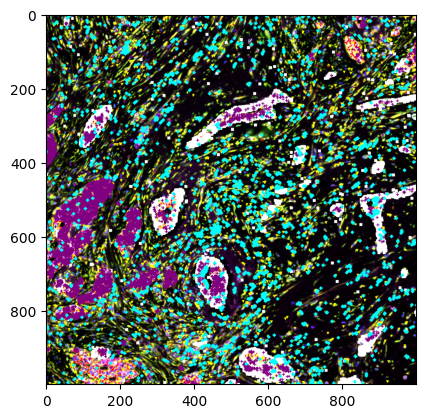

In [35]:
plt.imshow(rgb[2000:3000, 2000:3000])